In [1]:
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

2023-05-09 15:36:38.214834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 15:36:38.723849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 15:36:38.723883: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-09 15:36:39.966913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
root = "/home/sihartist/Desktop/"
path = root + "fraud-detection/dataset/preprocessing_data.xlsx"

In [4]:
data = pd.read_excel(path)

In [5]:
data.head()

,V1,V2,V3,V4,V9,V10,V12,V13,V16,V19,...,SIN(V7_day),SIN(V23_month),SIN(V23_day),SIN(V8_month),SIN(V8_day),V6_year,V7_year,V23_year,V8_year,CLASS
0,4,2,23,1,517511,478657.0,19,2976,44,20342,...,7.657137e-16,0.201299,0.937752,0.174152,-0.201299,2009,2011,2009,2009,0
1,4,2,23,1,656609,57651.0,19,2976,44,1351,...,7.657137e-16,0.201299,0.937752,-0.368810,0.937752,2009,2011,2009,2009,0
2,4,2,23,1,315952,166815.0,19,2976,44,25375,...,7.657137e-16,0.201299,0.937752,0.174152,-0.394356,2008,2009,2009,2009,0
3,4,2,23,1,475166,604595.0,19,2976,44,24577,...,7.657137e-16,0.201299,0.937752,0.174152,-0.571268,2009,2011,2009,2009,0
4,4,2,23,1,61685,665491.0,19,2976,44,17010,...,7.657137e-16,0.201299,0.937752,0.174152,-0.571268,2008,2010,2009,2009,0


In [6]:
x = data.drop(["CLASS"], axis=1)
y = data["CLASS"].values
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [31]:
len(x_norm)

70327

In [35]:
## input layer 
input_layer = Input(shape=(x.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(x.shape[1], activation='relu')(decoded)

In [36]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [37]:
history = autoencoder.fit(x_norm[0:60000], x_norm[0:60000], 
                batch_size = 256, epochs = 100, 
                shuffle = True, validation_split =0.20)

Epoch 1/100
188/188 [==============================] - 1s 5ms/step - loss: 0.2075 - val_loss: 0.2283
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 0.2038 - val_loss: 0.2238
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1993 - val_loss: 0.2181
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1935 - val_loss: 0.2106
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1858 - val_loss: 0.2009
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1761 - val_loss: 0.1904
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1662 - val_loss: 0.1811
Epoch 8/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1577 - val_loss: 0.1734
Epoch 9/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1506 - val_loss: 0.1671
Epoch 10/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1449 - val_lo

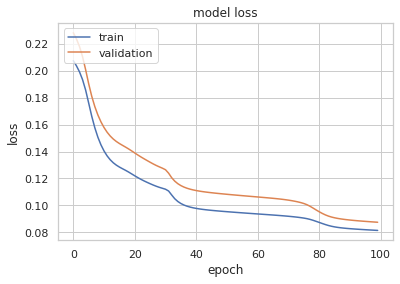

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
hid_rep = Sequential()
hid_rep.add(autoencoder.layers[0])
hid_rep.add(autoencoder.layers[1])
hid_rep.add(autoencoder.layers[2])

In [41]:
norm_hid_rep = hid_rep .predict(x_norm[60000:])
fraud_hid_rep = hid_rep .predict(x_fraud)

2198/2198 [==============================] - 2s 860us/step


In [42]:
non_fraud = data[data['CLASS'] == 0].sample(1000)
fraud = data[data['CLASS'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
df.head()

/tmp/ipykernel_84837/1249485764.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


,V1,V2,V3,V4,V9,V10,V12,V13,V16,V19,...,SIN(V7_day),SIN(V23_month),SIN(V23_day),SIN(V8_month),SIN(V8_day),V6_year,V7_year,V23_year,V8_year,CLASS
0,1,1,23,1,150000,300.000000,19,2976,44,58109,...,7.657137e-16,0.201299,0.937752,2.012985e-01,0.201299,2009,2011,2010,2010,1
1,0,1,2,1,10000,89596.363811,19,2976,61,41777,...,7.657137e-16,0.201299,0.937752,-1.224647e-16,0.101168,2008,2010,2011,2011,1
2,4,2,23,1,379231,37691.000000,19,2976,44,39166,...,7.657137e-16,0.201299,0.937752,6.652418e-01,-0.988468,2017,2019,2018,2018,1
3,4,2,23,1,540979,314511.583976,19,2932,44,25917,...,7.657137e-16,0.201299,0.937752,6.652418e-01,0.651372,2009,2011,2010,2010,1
4,1,1,23,1,150000,150000.000000,19,2976,104,47733,...,7.657137e-16,0.201299,0.937752,2.012985e-01,0.201299,2017,2019,2018,2018,1


In [44]:
X = df.drop(['CLASS'], axis = 1).values
Y = df["CLASS"].values

In [50]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    #plt.savefig(name)
    plt.show()
    
tsne_plot(X, Y, "original.png")

/home/sihartist/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sihartist/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TypeError: must be real number, not str

<Figure size 864x576 with 1 Axes>

In [ ]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression().fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("confusion_matrixt: ")
print (confusion_matrix(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))